# Knowledge Distillation

## 1. basics
- **Knowledge distillation** transfers knowledge from a large teacher model to a smaller student model,
    - by training the student on 2 things:
        - ground-truth labels and
        - the teacher’s soft predictions, which capture richer class relationships. 
- This improves the student’s generalization while reducing size, computation, and inference time. 
- Distillation methods:
    - logit-based
    - feature-based
    - response-based
    - and are often combined with pruning or quantization for efficiency.

## 2. Preliminary Theory

### Summary of Knowledge Distillation
- **Key Idea**:  
  The student model does not just learn a one-hot label, but the dense feature distribution predicted by the teacher model.
- **Ground Truth vs. Teacher Prediction**:  
  - Ground truth: one-hot encoding (hard target).  
  - Teacher output: probability distribution from softmax (T=1).  
  - With temperature T > 1, softmax outputs become smoother, revealing more information about class relationships.
- **Teacher Model**:  
  - Outputs logits:
    $$
    z(x) = [z1(x), z2(x), ..., zN(x)].
    $$
  - Softmax with temperature T gives -> **soft predicts**:  
    $$
    p_i(x) = \frac{\exp(z_i(x)/T)}{\sum_j \exp(z_j(x)/T)}
    $$
- **Student Model**:  
  - Predicts its own probability distribution q(x).  
  - Uses **KL divergence** to align with teacher’s distribution:  
    $$
    D_{KL}(p \| q) = \sum_i p_i(x) \log \frac{p_i(x)}{q_i(x)}
    $$
    $$
    Loss\ with\ scaling:  
    L_{KD} = T^2 D_{KL}
    $$
- **Final Loss Function**:  
  A weighted sum of hard-label loss and distillation loss:  
  $$
  L_{student} = \alpha L_{CE} + (1-\alpha)L_{KD}
  $$
  $$
  where\  L_{CE}  = cross-entropy\ with\ ground\ truth.$$

## 3. Model

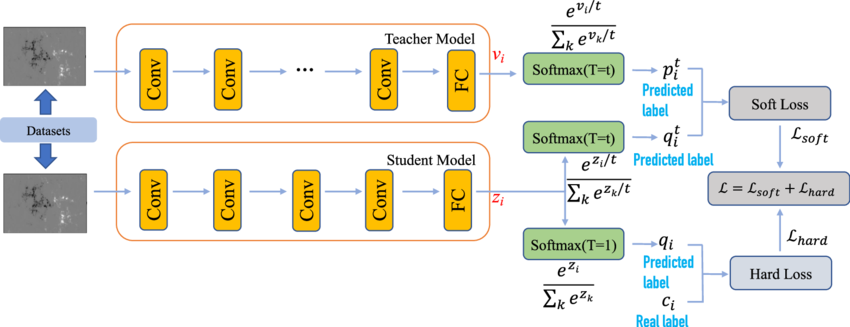

In [1]:
from IPython.display import Image
Image(filename='../Images/knowledge_distillation.png')

## 4. KD on pretraining
- For BERT -> pretraining + downstream tasks
    - BERT -> DistillBert

## 5. KD trainer arguments & trainer
$$
L_{student} = \alpha L_{CE} + (1-\alpha)L_{KD}
$$
$$
where\  L_{CE}  = cross\ entropy\ with\ ground\ truth.$$

In [2]:
from transformers import TrainingArguments, Trainer
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import wandb

In [3]:
class DistillTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha          # weight of hard-label CE
        self.temperature = temperature  # softmax temperature for KD

In [4]:
# Two hyper parameters
class DistillTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        
        # keep a fixed teacher; no grads & eval mode
        self.teacher_model = teacher_model.eval() if teacher_model is not None else None
        if self.teacher_model is not None:
            for p in self.teacher_model.parameters():
                p.requires_grad = False

    # main loss: blend hard CE and KD (KL with temperature)
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        s_out = model(**inputs)         # student forward
        loss = s_out.loss               # CE from HF model (hard labels)

        if self.teacher_model is not None:
            with torch.no_grad():       # freeze teacher
                t_logits = self.teacher_model(**inputs).logits

            T = self.args.temperature
            a = self.args.alpha
            
            # KL(student||teacher) with temperature; 
            # use log_softmax for student
            kd = F.kl_div(
                F.log_softmax(s_out.logits / T, dim=-1),
                F.softmax(t_logits / T, dim=-1),
                reduction="batchmean"
            ) * (T * T)                 # scale to keep gradient magnitude

            loss = a * loss + (1 - a) * kd

        return (loss, s_out) if return_outputs else loss

## 6. pipeline
### 6.1 datasets
dataset about text intent

In [5]:
from datasets import load_dataset
clinc = load_dataset("clinc_oos", "plus")

In [6]:
clinc

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

In [7]:
intents = clinc['train'].features['intent']
num_labels = intents.num_classes

# The number of all the intent
num_labels

151

### 6.2 Student mode initialize

In [8]:
from transformers import AutoConfig, AutoTokenizer
from transformers import AutoModelForSequenceClassification

device = "mps"

s_model = 'distilbert-base-uncased'
s_tokenizer = AutoTokenizer.from_pretrained(s_model)

t_model = 'transformersbook/bert-base-uncased-finetuned-clinc'
t_model = AutoModelForSequenceClassification.from_pretrained(t_model, num_labels=num_labels).to(device)

# map means apply the function to all the samples
clinc_enc = clinc.map(
    lambda batch: s_tokenizer(batch['text'], truncation=True), 
    batched=True, 
    remove_columns=["text"]
)
clinc_enc = clinc_enc.rename_columns({'intent': 'labels'})

In [9]:
batch_size = 64

s_training_args = DistillTrainingArguments(
    output_dir='distilbert-base-uncased-ft-clinc',
    eval_strategy='epoch',      
    logging_strategy='epoch',
    num_train_epochs=5,
    learning_rate=3e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    alpha=0.5,
    weight_decay=0.01,
    push_to_hub=False,
)

s_config = AutoConfig.from_pretrained(
    s_model,
    num_labels=num_labels,
    id2label=t_model.config.id2label,
    label2id=t_model.config.label2id,
)

In [10]:
def student_init():
    return AutoModelForSequenceClassification.from_pretrained(s_model, config=s_config).to(device)

### 6.3 Trainer train

In [11]:
import evaluate
accuracy_score = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    # HF passes an EvalPrediction with fields (predictions, label_ids)
    preds, labels = getattr(eval_pred, "predictions", eval_pred[0]), getattr(eval_pred, "label_ids", eval_pred[1])
    # Take argmax over last dim to get predicted class ids
    preds = np.argmax(preds, axis=-1)
    return accuracy_score.compute(predictions=preds, references=labels)

distill_trainer = DistillTrainer(
    model_init=student_init,          # lazy init for reproducibility / deepspeed
    teacher_model=t_model,            # fixed teacher (eval + no grad)
    args=s_training_args,
    train_dataset=clinc_enc["train"],
    eval_dataset=clinc_enc["validation"],
    compute_metrics=compute_metrics,
    processing_class=s_tokenizer,     # future-proof: tokenizer -> processing_class
)

distill_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: mrtanke2024 (damiano-baschiera-university-of-heidelberg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/opt/miniconda3/envs/bert/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### 6.4 Pratical use

In [ ]:
from transformers import pipeline

# ft_ckpt = 'lanchunhui/distilbert-base-uncased-ft-clinc'
# distill_trainer.push_to_hub('finetune completed!')

pipe = pipeline('text-classification', model='./distilbert-base-uncased-ft-clinc/')